In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss, precision_recall_curve
import xgboost as xgb
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [151]:
data = pd.read_csv('data_preprocessed/data_new_combined_featured_rank_6596.csv', index_col='Unnamed: 0') #drop(columns=['RedFighter', 'BlueFighter', 'Result'], axis=1)
# y = pd.read_csv('ufc-master-for-binary-classification.csv', index_col='Unnamed: 0')['Result']

In [152]:
data.columns

Index(['RedFighter', 'BlueFighter', 'RedStance', 'BlueStance', 'RedOdds',
       'BlueOdds', 'Result', 'Age_diff', 'Height_diff', 'Reach_diff',
       'Weight_diff', 'WinsByKO/TKO_diff', 'WinsBySubmission_diff',
       'WinsByDecision_diff', 'Red_Blue_Loss_diff', 'AvgSigStrLanded_diff',
       'AvgSigStrPct_diff', 'TDAvgLanded_diff', 'AvgTDPct_diff',
       'AvgSubAtt_diff', 'LongestWinStreak_diff', 'TotalRoundsFought_diff',
       'TimeSinceLastFight_diff', 'Rank_diff', 'Red_Blue_curr_streak_diff'],
      dtype='object')

In [137]:
df_test = pd.read_csv('data_preprocessed/data_new_featured_names_rank_3298.csv', index_col='Unnamed: 0')
df_test

,RedFighter,BlueFighter,RedStance,BlueStance,RedOdds,BlueOdds,Result,Age_diff,Height_diff,Reach_diff,...,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,LongestWinStreak_diff,TotalRoundsFought_diff,TimeSinceLastFight_diff,Rank_diff,Red_Blue_curr_streak_diff
1,Shavkat Rakhmonov,Ian Machado Garry,0.0,0.0,-210.0,295.0,0,3,-5.08,7.62,...,-1.38,0.060,0.7200,-0.260,1.5000,-2,-9,196,4.0,-2
2,Ciryl Gane,Alexander Volkov,0.0,0.0,-380.0,300.0,0,-2,-7.62,2.54,...,0.36,0.030,0.1300,-0.420,0.3000,3,-11,294,1.0,-3
3,Bryce Mitchell,Kron Gracie,1.0,1.0,-950.0,625.0,0,-6,2.54,0.00,...,-1.44,0.140,2.9800,0.160,1.1000,5,15,-224,3.0,1
4,Nate Landwehr,Dooho Choi,0.0,0.0,-130.0,110.0,1,3,-2.54,5.08,...,1.84,-0.070,0.2500,0.040,0.2000,0,2,112,0.0,0
5,Dominick Reyes,Anthony Smith,1.0,0.0,-380.0,300.0,0,-2,0.00,2.54,...,1.63,0.010,-0.1100,0.020,-0.3000,3,-42,21,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,Frank Mir,Shane Carwin,1.0,0.0,-150.0,140.0,1,-5,2.54,-2.54,...,3.00,0.083,0.4667,0.184,1.2667,1,17,0,0.0,-2
6512,Nate Diaz,Rory Markham,1.0,0.0,-235.0,195.0,0,-4,0.00,12.70,...,0.57,0.134,1.3333,0.476,1.4444,4,18,0,0.0,0
6518,Junior Dos Santos,Gabriel Gonzaga,0.0,0.0,-250.0,230.0,0,-4,5.08,2.54,...,-9.04,-0.010,-1.2000,-0.572,-0.7000,0,-10,0,0.0,3
6521,Clay Guida,Shannon Gugerty,0.0,0.0,-420.0,335.0,0,0,-7.62,-2.54,...,-8.18,0.061,2.1500,-0.281,-0.6500,2,19,0,0.0,-1


In [153]:
# data = data.loc[:2000, :]
X_train = data.drop(['Result', 'RedFighter', 'BlueFighter'], axis=1)
y_train = data['Result']

X_test = df_test.drop(['Result','RedFighter', 'BlueFighter'], axis=1)
y_test = df_test['Result']

In [154]:
train_size = int(len(X_train)*0.25)
test_size = int(len(df_test)*0.25)

X_train = X_train.iloc[train_size:, :]
y_train = y_train.iloc[train_size:]
# X_test = X.iloc[:test_size, :]
# y_test = y.iloc[:test_size]
X_test = X_test.iloc[:test_size, :]
y_test = y_test.iloc[:test_size]

In [155]:
X_train

,RedStance,BlueStance,RedOdds,BlueOdds,Age_diff,Height_diff,Reach_diff,Weight_diff,WinsByKO/TKO_diff,WinsBySubmission_diff,...,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,LongestWinStreak_diff,TotalRoundsFought_diff,TimeSinceLastFight_diff,Rank_diff,Red_Blue_curr_streak_diff
1123,0.0,1.0,175.0,-205.0,-6,-7.62,-7.62,0,0,0,...,-0.53,-0.010,-0.53,0.080,-0.10,-1,-3,-133,6.0,5
1124,0.0,0.0,-130.0,110.0,3,0.00,12.70,-15,1,0,...,-1.43,0.050,-2.74,-0.410,-0.20,1,-5,28,0.0,2
1124,0.0,0.0,110.0,-130.0,-3,0.00,-12.70,15,-1,0,...,1.43,-0.050,2.74,0.410,0.20,-1,5,-28,0.0,-2
1125,0.0,1.0,-135.0,115.0,-1,-2.54,2.54,0,2,0,...,-2.00,-0.140,1.12,-0.070,0.10,0,26,77,0.0,-4
1125,1.0,0.0,115.0,-135.0,1,2.54,-2.54,0,-2,0,...,2.00,0.140,-1.12,0.070,-0.10,0,-26,-77,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6518,0.0,0.0,230.0,-250.0,4,-5.08,-2.54,4,1,2,...,9.04,0.010,1.20,0.572,0.70,0,10,0,0.0,-3
6521,0.0,0.0,-420.0,335.0,0,-7.62,-2.54,0,1,-1,...,-8.18,0.061,2.15,-0.281,-0.65,2,19,0,0.0,-1
6521,0.0,0.0,335.0,-420.0,0,7.62,2.54,0,-1,1,...,8.18,-0.061,-2.15,0.281,0.65,-2,-19,0,0.0,1
6525,0.0,0.0,-260.0,220.0,0,2.54,2.12,-20,0,0,...,4.00,-0.090,-1.00,-1.000,-1.00,0,0,0,0.0,0


In [156]:
# Масштабируйте данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### XGBoost

In [157]:
def objective(trial):
    # Определение гиперпараметров для оптимизации
    max_depth = trial.suggest_int('max_depth', 1, 16)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 2, 100)
    gamma = trial.suggest_loguniform('gamma', 0.01, 10.0)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.2, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 0.01, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 0.01, 10.0)

    # Создание модели
    model = xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate,
                              n_estimators=n_estimators, gamma=gamma,
                              subsample=subsample, colsample_bytree=colsample_bytree,
                              reg_alpha=reg_alpha, reg_lambda=reg_lambda)

    # Обучение модели
    model.fit(X_train_scaled, y_train)

    # Оценка модели
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)

    return f1

# Создание Bayesian Optimization
study = optuna.create_study(direction='maximize')

# Запуск Bayesian Optimization
study.optimize(objective, n_trials=200)

# Вывод лучших гиперпараметров и результата
# print("Лучшие гиперпараметры:", study.best_params)
# print("Результат:", study.best_value)

# Создание модели с лучшими гиперпараметрами
best_model = xgb.XGBClassifier(**study.best_params)
best_model.fit(X_train_scaled, y_train)

# Оценка модели с лучшими гиперпараметрами
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
print("F1-мера модели с лучшими гиперпараметрами:", f1_score(y_test, y_pred, average='weighted'))
# Вывод параметров лучшей модели
print("Параметры лучшей модели:", best_model.get_params())

[I 2025-01-21 15:26:05,030] A new study created in memory with name: no-name-9390ab9d-853f-46fb-b7d9-3bd9de638c59
[I 2025-01-21 15:26:05,094] Trial 0 finished with value: 0.6369047619047619 and parameters: {'max_depth': 1, 'learning_rate': 0.014295714286656916, 'n_estimators': 46, 'gamma': 3.163465492737036, 'subsample': 0.7960483216331795, 'colsample_bytree': 0.9597818978178958, 'reg_alpha': 0.016755602091569528, 'reg_lambda': 0.3405650219605358}. Best is trial 0 with value: 0.6369047619047619.
[I 2025-01-21 15:26:05,205] Trial 1 finished with value: 0.6472222222222223 and parameters: {'max_depth': 3, 'learning_rate': 0.056179705343126836, 'n_estimators': 81, 'gamma': 5.242648872244997, 'subsample': 0.6521167526203988, 'colsample_bytree': 0.7159466074750469, 'reg_alpha': 3.8957643001760367, 'reg_lambda': 0.0135343383480364}. Best is trial 1 with value: 0.6472222222222223.
[I 2025-01-21 15:26:05,328] Trial 2 finished with value: 0.6132208157524613 and parameters: {'max_depth': 10, 'lea

F1-мера модели с лучшими гиперпараметрами: 0.7114241026366221
Параметры лучшей модели: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9375589388327585, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.025670772482754026, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01124456210897175, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 31, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 0.10500235180705117, 'reg_lambda': 1.4984553087296444, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.7268604651935853,

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       465
           1       0.67      0.68      0.67       359

    accuracy                           0.71       824
   macro avg       0.71      0.71      0.71       824
weighted avg       0.71      0.71      0.71       824



Text(0.5, 23.52222222222222, 'predicted value')

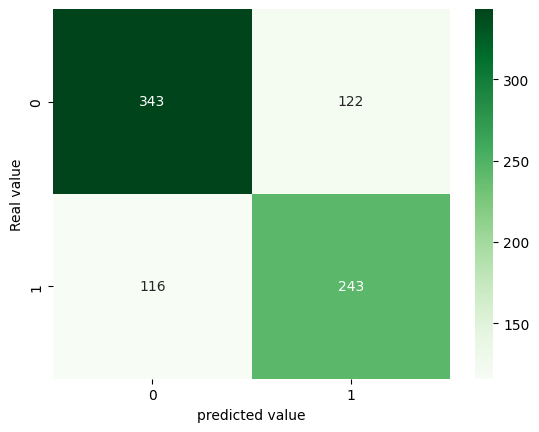

In [158]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

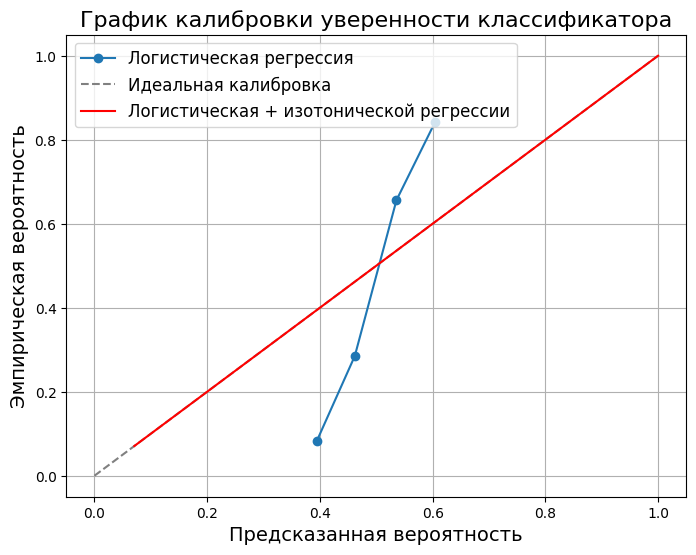

In [159]:
from sklearn.calibration import calibration_curve, FrozenEstimator, CalibratedClassifierCV


# Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy="uniform")

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Логистическая регрессия')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')

# Каоибровка вероятностей
calibrated_model_iso = CalibratedClassifierCV(FrozenEstimator(best_model), method='isotonic', cv='prefit')
calibrated_model_iso.fit(X_test_scaled, y_test)

# Предсказанные вероятности после калибровки
calibrated_probs_iso = calibrated_model_iso.predict_proba(X_test_scaled)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs_iso, n_bins=10, strategy="uniform")
plt.plot(prob_pred, prob_true, color='red', label='Логистическая + изотонической регрессии')
plt.xlabel('Предсказанная вероятность', fontsize=14)
plt.ylabel('Эмпирическая вероятность', fontsize=14)
plt.title('График калибровки уверенности классификатора', fontsize=16)
plt.legend(fontsize=12)
plt.grid()

### Еще одна Optuna

In [102]:
# Определение целевой функции для оптимизации
def objective(trial):
    # Определение гиперпараметров для перебора
    params = {
            'max_depth': trial.suggest_int('max_depth', 5, 40),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
            'n_estimators': trial.suggest_int('n_estimators', 50, 250),
            'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 10),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.01, 10),
            'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 100)
    }

    # Обучение модели
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', **params)
    xgb_model.fit(X_train_scaled, y_train)

    # Предсказание на тестовой выборке
    y_pred = xgb_model.predict(X_test_scaled)
    # y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

    # Расчет метрики PR-AUC
    # precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
    # pr_auc = auc(recall_pr, precision_pr)
    f1 = f1_score(y_test, y_pred)

    return f1

# Перебор гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=60)

# Обучение лучшей модели
best_params = study.best_params
best_model = xgb.XGBClassifier(objective='binary:logistic', **best_params)
best_model.fit(X_train_scaled, y_train)

# Предсказание на тестовой выборке
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Расчет метрик
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_pr, precision_pr)

# Вывод метрик
print('Лучшие гиперпараметры:', best_params)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC: {pr_auc:.4f}')

[I 2025-01-21 14:22:31,358] A new study created in memory with name: no-name-e0a58757-bc9f-4287-9534-fb8f2cc149dc
[I 2025-01-21 14:22:31,911] Trial 0 finished with value: 0.6391752577319587 and parameters: {'max_depth': 26, 'learning_rate': 0.22376942371460443, 'n_estimators': 216, 'gamma': 0.6243101485049816, 'subsample': 0.5413470742143957, 'colsample_bytree': 0.6355757830441864, 'reg_alpha': 0.5468015871533222, 'reg_lambda': 0.2297839517095721, 'scale_pos_weight': 6}. Best is trial 0 with value: 0.6391752577319587.
[I 2025-01-21 14:22:32,881] Trial 1 finished with value: 0.6487523992322457 and parameters: {'max_depth': 14, 'learning_rate': 0.043941702765193914, 'n_estimators': 162, 'gamma': 0.0151823033573088, 'subsample': 0.8027538876779244, 'colsample_bytree': 0.7128932153168532, 'reg_alpha': 0.010174510802721613, 'reg_lambda': 1.1202909657756661, 'scale_pos_weight': 57}. Best is trial 1 with value: 0.6487523992322457.
[I 2025-01-21 14:22:32,998] Trial 2 finished with value: 0.609

Лучшие гиперпараметры: {'max_depth': 25, 'learning_rate': 0.022257097897753975, 'n_estimators': 214, 'gamma': 0.02016375831402493, 'subsample': 0.6164000508191605, 'colsample_bytree': 0.6200462688834271, 'reg_alpha': 0.19845123201918516, 'reg_lambda': 0.20326486831458382, 'scale_pos_weight': 21}
Precision: 0.5305
Recall: 0.9192
F1: 0.6728
ROC-AUC: 0.7306
PR-AUC: 0.6602


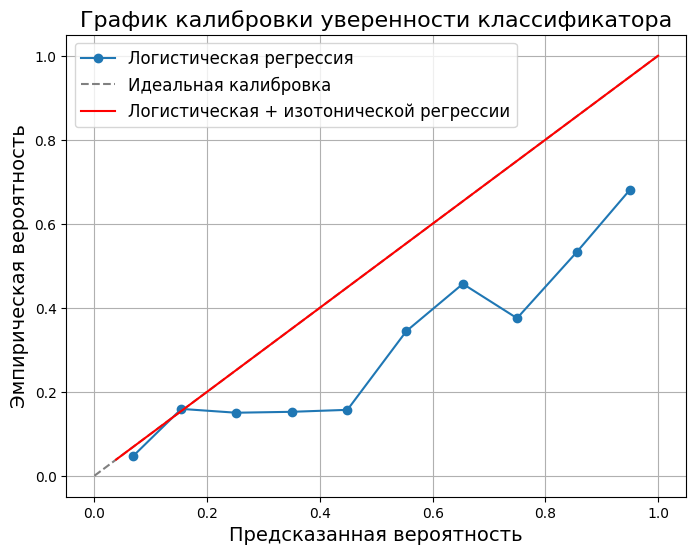

In [103]:
from sklearn.calibration import calibration_curve, FrozenEstimator, CalibratedClassifierCV


# Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy="uniform")

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Логистическая регрессия')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')

# Каоибровка вероятностей
calibrated_model_iso = CalibratedClassifierCV(FrozenEstimator(best_model), method='isotonic', cv='prefit')
calibrated_model_iso.fit(X_test_scaled, y_test)

# Предсказанные вероятности после калибровки
calibrated_probs_iso = calibrated_model_iso.predict_proba(X_test_scaled)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs_iso, n_bins=10, strategy="uniform")
plt.plot(prob_pred, prob_true, color='red', label='Логистическая + изотонической регрессии')
plt.xlabel('Предсказанная вероятность', fontsize=14)
plt.ylabel('Эмпирическая вероятность', fontsize=14)
plt.title('График калибровки уверенности классификатора', fontsize=16)
plt.legend(fontsize=12)
plt.grid()

In [104]:
y_pred = calibrated_model_iso.predict(X_test_scaled)

precision_pr, recall_pr, _ = precision_recall_curve(y_test, calibrated_probs_iso )
pr_auc = auc(recall_pr, precision_pr)

log_reg_recall = recall_score(y_test, y_pred, average='weighted')
log_reg_precision = precision_score(y_test, y_pred, average='weighted')
log_reg_f1 = f1_score(y_test, y_pred, average='weighted')
log_reg_accuracy = accuracy_score(y_test, y_pred)
log_reg_roc_auc = roc_auc_score(y_test, calibrated_probs_iso, average='weighted')

log_reg_metrics = [(np.round(log_reg_recall, 3),
                    np.round(log_reg_precision, 3),
                    np.round(log_reg_f1, 3),
                    np.round(log_reg_accuracy, 3),
                    np.round(log_reg_roc_auc, 3),
                    np.round(pr_auc, 3))]

metrics = pd.DataFrame(data = log_reg_metrics, columns=['Recall','Precision','F1 Score', 'Accuracy', 'ROC-AUC', 'PR-AUC'])
metrics.insert(0, 'Model', 'LogReg+Isotonic Regression')
metrics

,Model,Recall,Precision,F1 Score,Accuracy,ROC-AUC,PR-AUC
0,LogReg+Isotonic Regression,0.681,0.682,0.67,0.681,0.743,0.682


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       465
           1       0.69      0.49      0.57       359

    accuracy                           0.68       824
   macro avg       0.68      0.66      0.66       824
weighted avg       0.68      0.68      0.67       824



Text(0.5, 23.52222222222222, 'predicted value')

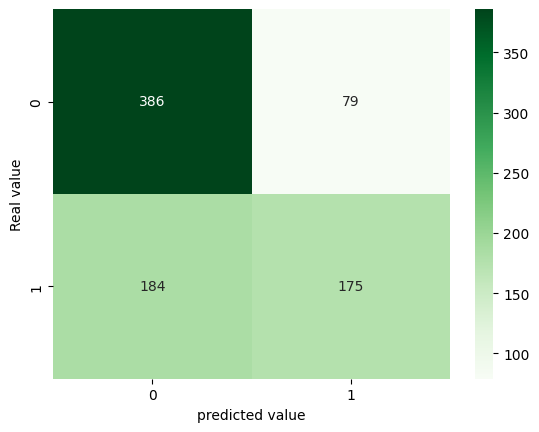

In [105]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### Метрика оценки качества

In [131]:
def calc_odds(row):
    for col in ['RedOdds', 'BlueOdds']:
        if row[col] > 0:
            row[col] = row[col] / 100 + 1
        else:
            row[col] = 100 / np.abs(row[col]) + 1
    return row

import random

def calc_model_gain(row, stake_size = 1000):
    if row['Prediction_Errors'] == 0:
        return int((row['RedOdds'], row['BlueOdds'])[row['ActualWinner']] * stake_size)
    else:
        return - stake_size
    
def calc_odds_gain(row, stake_size = 1000):
    if row['ActualWinner'] == 0 and row['RedOdds'] < row['BlueOdds']:
        return int(row['RedOdds'] * stake_size)
    elif row['ActualWinner'] == 1 and row['RedOdds'] > row['BlueOdds']:
        return int(row['BlueOdds'] * stake_size)
    else:
        return - stake_size


def calc_guess_gain(row, stake_size = 1000):
    odds = (row['RedOdds'], row['BlueOdds'])
    odds_number = (0, 1)
    chosen_odd = random.choice(odds_number)  # Выбираем случайный элемент из кортежа
    if chosen_odd == row['ActualWinner']:
        return int(odds[chosen_odd] * stake_size)
    else:
        return - stake_size

In [132]:
# fighters = pd.read_csv('data_preprocessed/data_new_featured__with_odds_names_3298.csv', index_col='Unnamed: 0')
fighters = pd.read_csv('data_preprocessed/data_new_featured_names_rank_3298.csv', index_col='Unnamed: 0')

In [160]:
y_proba = calibrated_model_iso.predict_proba(X_test_scaled)

# Создание датафрейма для хранения результатов
results_df = pd.DataFrame({
    'RedFighter': fighters['RedFighter'].iloc[:test_size],
    'BlueFighter': fighters['BlueFighter'].iloc[:test_size],
    'RedOdds': fighters['RedOdds'].iloc[:test_size],
    'BlueOdds': fighters['BlueOdds'].iloc[:test_size],
    'ProbabilityRedWins': y_proba [:, 0],
    'ProbabilityBlueWins': y_proba [:, 1],
    'ActualWinner': fighters['Result'].iloc[:test_size]
})

results_df['Predicted_Winner'] = (results_df['ProbabilityBlueWins'] > results_df['ProbabilityRedWins']).astype(int)
results_df['Prediction_Errors'] = np.abs(results_df['Predicted_Winner'] - results_df['ActualWinner'])
results_df.iloc[:30, :]

,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbabilityRedWins,ProbabilityBlueWins,ActualWinner,Predicted_Winner,Prediction_Errors
1,Shavkat Rakhmonov,Ian Machado Garry,-210.0,295.0,0.826087,0.173913,0,0,0
2,Ciryl Gane,Alexander Volkov,-380.0,300.0,0.929577,0.070423,0,0,0
3,Bryce Mitchell,Kron Gracie,-950.0,625.0,0.929577,0.070423,0,0,0
4,Nate Landwehr,Dooho Choi,-130.0,110.0,0.592593,0.407407,1,0,1
5,Dominick Reyes,Anthony Smith,-380.0,300.0,0.774194,0.225806,0,0,0
6,Vicente Luque,Themba Gorimbo,-650.0,-162.0,0.592593,0.407407,0,0,0
7,Movsar Evloev,Aljamain Sterling,-238.0,195.0,0.700000,0.300000,0,0,0
8,Randy Brown,Bryan Battle,150.0,-180.0,0.303797,0.696203,1,1,0
9,Chris Weidman,Eryk Anders,-112.0,-108.0,0.458333,0.541667,1,1,0
10,Cody Durden,Joshua Van,142.0,-170.0,0.458333,0.541667,1,1,0


In [161]:
results_df = results_df.apply(calc_odds, axis=1)
results_df['Gain_model'] = results_df.apply(calc_model_gain, axis=1)
results_df['Gain_odds'] = results_df.apply(calc_odds_gain, axis=1)
results_df['Gain_guess'] = results_df.apply(calc_guess_gain, axis=1)

print(f'Результат выигрыша при использовании модели: {results_df['Gain_model'].sum()} рублей')
print(f'Результат выигрыша при использовании ставок: {results_df['Gain_odds'].sum()} рублей')
print(f'Результат выигрыша при слепом угадывании: {results_df['Gain_guess'].sum()} рублей')

Результат выигрыша при использовании модели: 644164 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при слепом угадывании: 330025 рублей


In [162]:
results_df

,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbabilityRedWins,ProbabilityBlueWins,ActualWinner,Predicted_Winner,Prediction_Errors,Gain_model,Gain_odds,Gain_guess
1,Shavkat Rakhmonov,Ian Machado Garry,1.476190,3.950000,0.826087,0.173913,0,0,0,1476,1476,1476
2,Ciryl Gane,Alexander Volkov,1.263158,4.000000,0.929577,0.070423,0,0,0,1263,1263,1263
3,Bryce Mitchell,Kron Gracie,1.105263,7.250000,0.929577,0.070423,0,0,0,1105,1105,1105
4,Nate Landwehr,Dooho Choi,1.769231,2.100000,0.592593,0.407407,1,0,1,-1000,-1000,2100
5,Dominick Reyes,Anthony Smith,1.263158,4.000000,0.774194,0.225806,0,0,0,1263,1263,1263
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,1.555556,2.550000,0.666667,0.333333,1,0,1,-1000,-1000,2550
1118,Ilir Latifi,Aleksei Oleinik,1.512821,2.650000,0.666667,0.333333,0,0,0,1512,1512,1512
1119,Joaquim Silva,Jesse Ronson,1.714286,2.200000,0.666667,0.333333,0,0,0,1714,1714,-1000
1120,Krzysztof Jotko,Brendan Allen,1.800000,2.050000,0.666667,0.333333,1,0,1,-1000,-1000,2050


In [16]:
# Инициализация пустого DataFrame
metrics = pd.DataFrame(columns=['Threshold', 'Recall', 'Precision', 'F1 Score'])

# fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(16,16))
thresholds = np.arange(0.1, 1, 0.1)

for i in range(9):

    predictions = (calibrated_probs_iso  >= thresholds[i]).astype(int)
    precision_pr, recall_pr, _ = precision_recall_curve(y_test, calibrated_probs_iso )
    pr_auc = auc(recall_pr, precision_pr)
    log_reg_recall = recall_score(y_test, predictions)
    log_reg_precision = precision_score(y_test, predictions)
    log_reg_f1 = f1_score(y_test, predictions)
    log_reg_accuracy = accuracy_score(y_test, predictions)
    log_reg_roc_auc = roc_auc_score(y_test, predictions)

   # Создание новой строки в виде DataFrame
    new_row = pd.DataFrame(data=[[thresholds[i],
                                np.round(log_reg_recall, 3),
                                np.round(log_reg_precision, 3),
                                np.round(log_reg_f1, 3)]],                              

                            columns=['Threshold', 'Recall', 'Precision', 'F1 Score']
                            )

    # Добавление строки с помощью pd.concat
    metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

,Threshold,Recall,Precision,F1 Score
0,0.1,0.997,0.445,0.616
1,0.2,0.908,0.532,0.671
2,0.3,0.880,0.555,0.681
3,0.4,0.877,0.557,0.681
4,0.5,0.760,0.592,0.666
5,0.6,0.343,0.707,0.462
6,0.7,0.262,0.734,0.386
7,0.8,0.006,1.000,0.011
8,0.9,0.006,1.000,0.011


### PyTorch

In [61]:
y_train =np.array(y_train)
y_test =np.array(y_test)

In [156]:
# # Стандартизация данных
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_scaled)
# X_test_scaled = scaler.transform(X_test_scaled)

# Определение нейросети
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out
    
# Параметры модели
input_size = X_train_scaled.shape[1]
hidden_size = 64
num_classes = 2
learning_rate = 0.01
num_epochs = 25
batch_size = 32

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Инициализация модели, функции потерь и оптимизатора
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [157]:
# Обучение модели
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [5/25], Loss: 0.1754
Epoch [10/25], Loss: 0.1426
Epoch [15/25], Loss: 0.0024
Epoch [20/25], Loss: 1.2745
Epoch [25/25], Loss: 0.0135


In [158]:
# Оценка модели
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)

    # Расчет метрик
    precision = precision_score(y_test_tensor, predicted)
    recall = recall_score(y_test_tensor, predicted)
    f1 = f1_score(y_test_tensor, predicted)
    roc_auc = roc_auc_score(y_test_tensor, predicted)
    precision_pr, recall_pr, _ = precision_recall_curve(y_test_tensor, predicted)
    pr_auc = auc(recall_pr, precision_pr)

    # Вывод метрик
    print('Лучшие гиперпараметры:', best_params)
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1: {f1:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')
    print(f'PR-AUC: {pr_auc:.4f}')
    # accuracy = correct / total
    # print(f'Accuracy: {accuracy:.4f}')

    # # Вычисление F1-меры
    # f1 = f1_score(y_test_tensor, predicted, average='weighted')
    # print(f'F1 Score: {f1:.4f}')

Лучшие гиперпараметры: {'max_depth': 29, 'learning_rate': 0.11058475344177539, 'n_estimators': 138, 'gamma': 0.1641858305097053, 'subsample': 0.9333242759356728, 'colsample_bytree': 0.8073231035632892, 'reg_alpha': 0.05154588793325382, 'reg_lambda': 0.035989562823252434, 'scale_pos_weight': 81}
Precision: 0.6176
Recall: 0.5122
F1: 0.5600
ROC-AUC: 0.6243
PR-AUC: 0.6756


### Аугментация данных

In [106]:
# Функция для аугментации данных
def augment_data(X, y, noise_level=0.05):
    noise = np.random.normal(0, noise_level, X.shape)
    X_augmented = X + noise
    y_augmented = y.copy()
    return X_augmented, y_augmented

# Аугментация тренировочных данных
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

# Преобразование аугментированных данных в тензоры
X_train_augmented_tensor = torch.tensor(X_train_augmented.values, dtype=torch.float32)
# y_train_augmented_tensor = torch.tensor(y_train_augmented.values, dtype=torch.long)

# Создание DataLoader для аугментированных данных
train_dataset_augmented = TensorDataset(X_train_augmented_tensor, y_train_tensor)
train_loader_augmented = DataLoader(dataset=train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Обучение модели на аугментированных данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader_augmented):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.4619
Epoch [20/50], Loss: 0.5882
Epoch [30/50], Loss: 0.7323
Epoch [40/50], Loss: 0.2242
Epoch [50/50], Loss: 0.9054


In [107]:
# Оценка модели после обучения на аугментированных данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after augmentation: {accuracy:.4f}')

    # Вычисление F1-меры
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after augmentation: {f1:.4f}')

Accuracy after augmentation: 0.7048
F1 Score after augmentation: 0.7054


### Датасет + аугментированный датасет

In [115]:
# # Стандартизация данных
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Определение нейросети
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Параметры модели
input_size = X_train.shape[1]
hidden_size = 128
num_classes = 2
learning_rate = 0.01
num_epochs = 50
batch_size = 32

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Создание DataLoader для базовых данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Функция для аугментации данных
def augment_data(X,noise_level=0.04):
    noise = np.random.normal(0, noise_level, X.shape)
    X_augmented = X + noise  
    return X_augmented

# Аугментация тренировочных данных
X_train_augmented = augment_data(X_train)

# Преобразование аугментированных данных в тензоры
X_train_augmented_tensor = torch.tensor(X_train_augmented.values, dtype=torch.float32)

# Создание DataLoader для аугментированных данных
train_dataset_augmented = TensorDataset(X_train_augmented_tensor, y_train_tensor)
train_loader_augmented = DataLoader(dataset=train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Инициализация модели, функции потерь и оптимизатора
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение модели на базовых данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели после обучения на базовых данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after training on base data: {accuracy:.4f}')

    # Вычисление F1-меры
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after training on base data: {f1:.4f}')

# Обучение модели на аугментированных данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader_augmented):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели после обучения на аугментированных данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after training on augmented data: {accuracy:.4f}')

    # Вычисление F1-меры
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after training on augmented data: {f1:.4f}')

Epoch [10/50], Loss: 0.7182
Epoch [20/50], Loss: 0.6200
Epoch [30/50], Loss: 0.7629
Epoch [40/50], Loss: 0.6408
Epoch [50/50], Loss: 1.0006
Accuracy after training on base data: 0.5646
F1 Score after training on base data: 0.4824
Epoch [10/50], Loss: 0.7426
Epoch [20/50], Loss: 0.8075
Epoch [30/50], Loss: 0.8374
Epoch [40/50], Loss: 0.8176
Epoch [50/50], Loss: 0.0049
Accuracy after training on augmented data: 0.5609
F1 Score after training on augmented data: 0.4594
